<a href="https://colab.research.google.com/github/overthemoon0/Playground-Series-Regression/blob/main/playground_regressor_predict_age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Playground regressor - predicting crab age using blended CatBoost and LGBM exctracted from PyCaret

## Table of contents
- Importing libraries
- EDA
- Preprocessing 
- Modelling
- Submission
- Suggestions for improvement

### Importing libraries

In [ ]:
# BASE
import numpy as np
import pandas as pd
import warnings

# DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns


# CONFIGURATIONS
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Import necessary libraries
import xgboost as xgb
import lightgbm as lgb
!pip install pycaret --quiet
from pycaret.regression import *
from catboost import CatBoostRegressor

# sklearn
from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.model_selection import *


### EDA

In [ ]:
train = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')

In [ ]:
train.dtypes

id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Age                 int64
dtype: object

In [ ]:
train.head(2)

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.52,1.18,0.38,28.97,12.73,6.65,8.35,9
1,1,I,1.10,0.82,0.28,10.42,4.52,2.32,3.40,8


In [ ]:
print("amount of rows with missing values in train dataset:")
print(train.isna().any(axis=1).sum())
print("amount of rows with missing values in test dataset:")
print(test.isna().any(axis=1).sum())

amount of rows with missing values in train dataset:
0
amount of rows with missing values in test dataset:
0


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,74051.00,37025.00,21376.83,0.00,18512.50,37025.00,55537.50,74050.00
Length,74051.00,1.32,0.29,0.19,1.15,1.38,1.54,2.01
Diameter,74051.00,1.02,0.24,0.14,0.89,1.07,1.20,1.61
Height,74051.00,0.35,0.09,0.00,0.30,0.36,0.41,2.83
Weight,74051.00,23.39,12.65,0.06,13.44,23.80,32.16,80.10
Shucked Weight,74051.00,10.10,5.62,0.03,5.71,9.91,14.03,42.18
Viscera Weight,74051.00,5.06,2.79,0.04,2.86,4.99,6.99,21.55
Shell Weight,74051.00,6.72,3.58,0.04,3.97,6.93,9.07,28.49
Age,74051.00,9.97,3.18,1.00,8.00,10.00,11.00,29.00


In [ ]:
train.describe(include='object').T

,count,unique,top,freq
Sex,74051,3,M,27084


<Axes: xlabel='Sex', ylabel='Age'>

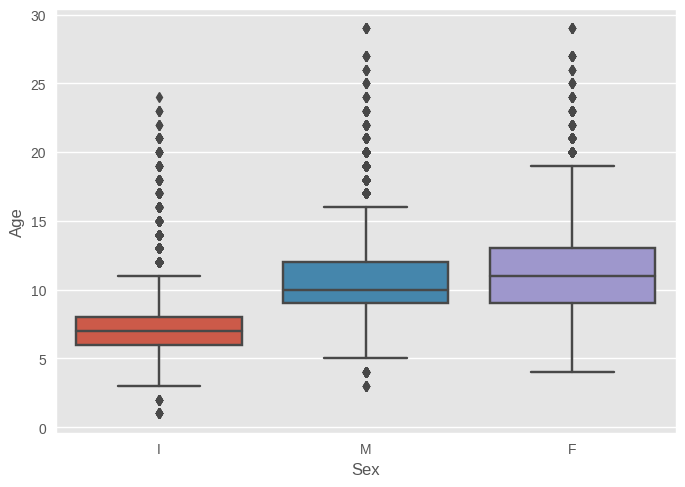

In [ ]:
# distribution of target within the only categorical variable
sns.boxplot(train, y = 'Age', x = 'Sex')

<Axes: xlabel='id', ylabel='Age'>

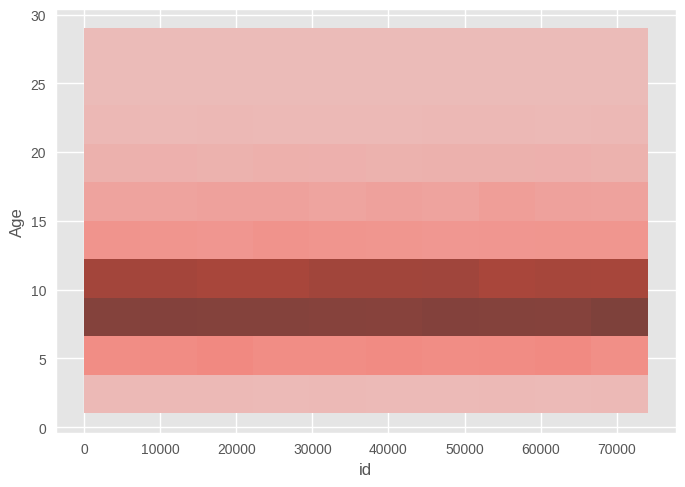

In [ ]:
sns.histplot(data=train, x='id', y = "Age", bins = 10)

No leakage detected. The column may be ignored

In [ ]:
# Concatinating train and test datasets
complete = pd.concat([test.assign(ind="test"), train.assign(ind="train")]) ## assigning markers for the test and train sets
complete.reset_index(level=0, inplace=True)
complete.head(2)

,index,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,ind,Age
0,0,74051,I,1.05,0.76,0.28,8.62,3.66,1.73,2.72,test,NaN
1,1,74052,I,1.16,0.89,0.28,15.51,7.03,3.25,3.97,test,NaN


Text(0.5, 1.0, 'Correlation of variables')

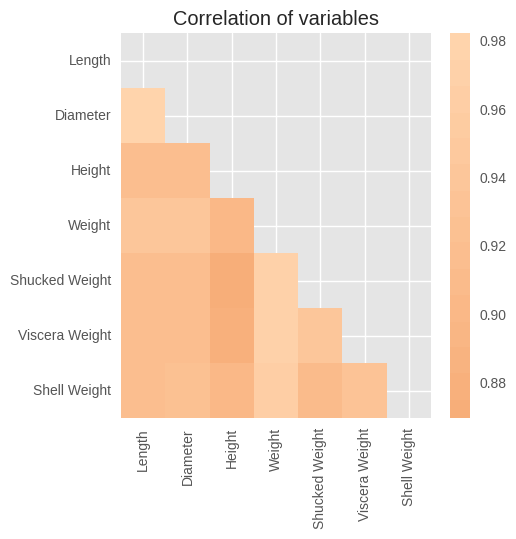

In [ ]:
numeric_features=['Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight']

# building correlation matrix
plt.figure(figsize = (5,5))
corr = complete[numeric_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True,center = 0,square = False) ## building correlation matrix
plt.title('Correlation of variables')

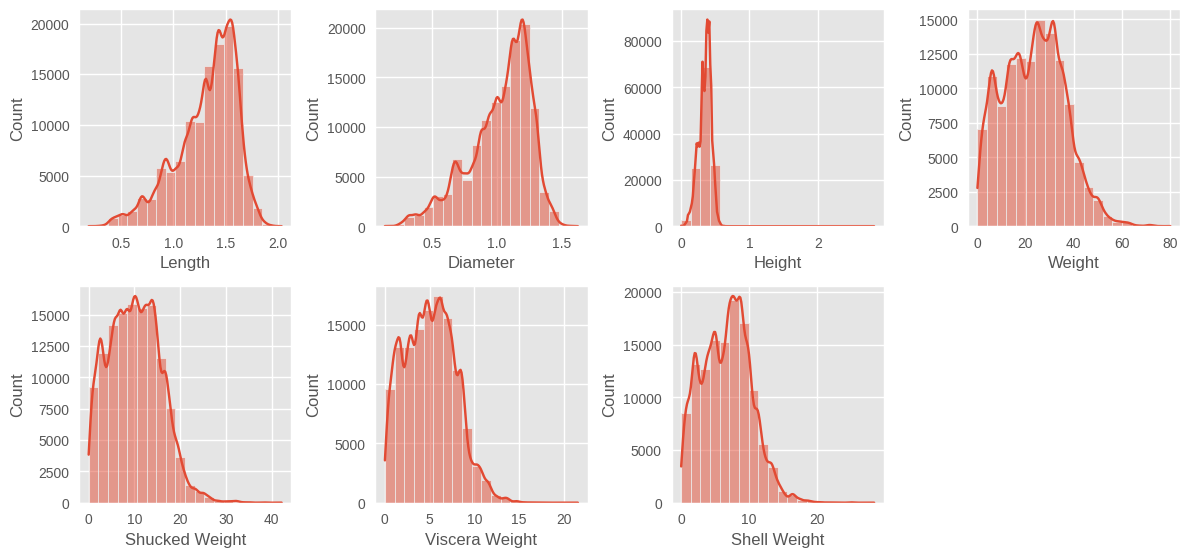

In [ ]:


# Plot  features
fig=plt.figure(figsize=(12,8))
for i, var_name in enumerate(numeric_features):
    ax=fig.add_subplot(3,4,i+1) 
    sns.histplot(data=complete, x=var_name, bins=20, kde=True, alpha = 0.5)   
plt.tight_layout()

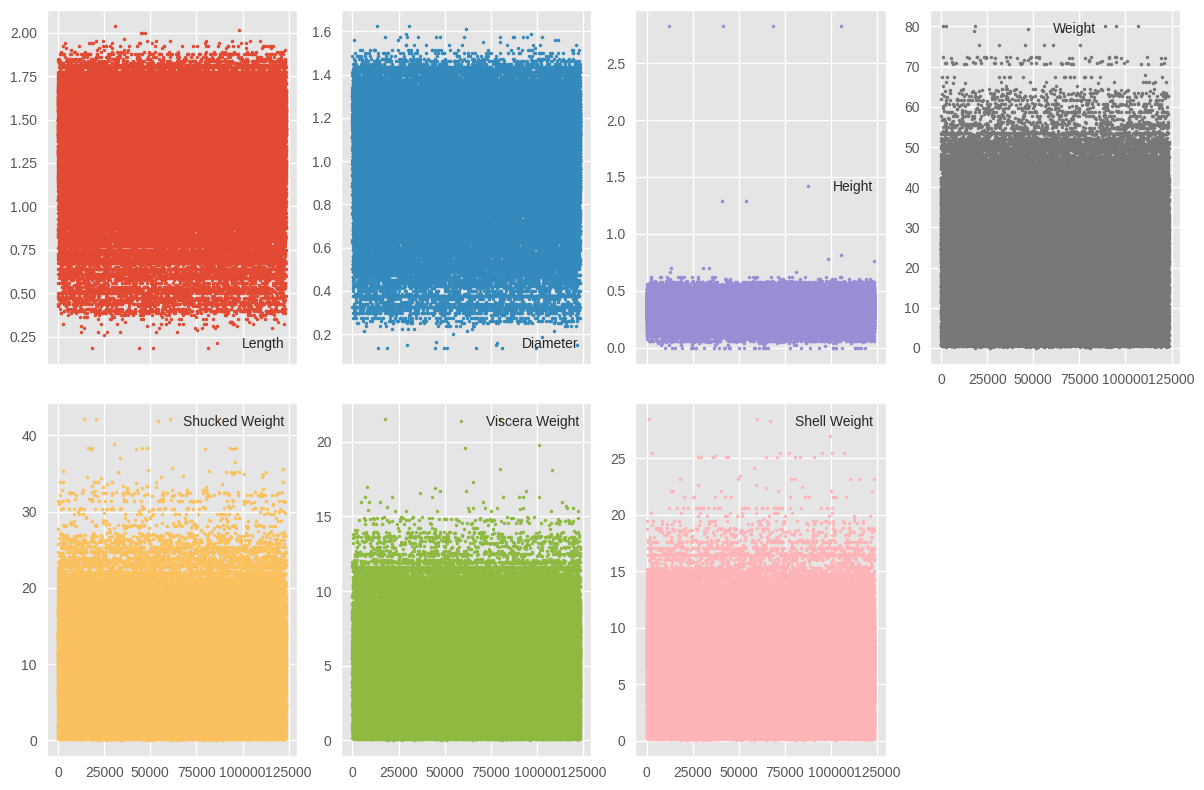

In [ ]:
complete[numeric_features].plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(12,8), markersize=5)
plt.tight_layout()

### Preprocessing

#### Outlier imputation

In [ ]:
def remove_outliers(df, num_std=3, replace_with=np.nan):
    """
    Function for removing outliers in all columns of data based on the number of standard deviations.
    df: data dataframe
    num_std: number of standard deviations (int), defaults to 3
    replace_with: new value for outliers (int/float/np.nan), defaults to np.nan.
    """
    for column in df.columns:
        mean = df[column].mean()
        std = df[column].std()
        lower_bound = mean - num_std * std
        upper_bound = mean + num_std * std

        df.loc[(df[column] <= lower_bound) | (df[column] >= upper_bound), column] = replace_with
        
    return df

In [ ]:
complete[numeric_features] = remove_outliers(complete[numeric_features], num_std = 3)

In [ ]:
print('Amount of detected outliers:\n', 
      
      complete[numeric_features].isna().sum())

Amount of detected outliers:
 Length            799
Diameter          578
Height            283
Weight            351
Shucked Weight    450
Viscera Weight    351
Shell Weight      458
dtype: int64


In [ ]:
# imputing with KNN
imputer = KNNImputer(n_neighbors=5)
KNN_imputation = imputer.fit_transform(complete[numeric_features])
complete[numeric_features] = KNN_imputation

In [ ]:
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(complete[numeric_features]), columns = [name + '_scaled' for name in numeric_features])
scaled_complete = pd.concat([complete, scaled_features], axis = 1)
scaled_complete.drop(columns = numeric_features, inplace = True)
scaled_complete.head(2)

,index,id,Sex,ind,Age,Length_scaled,Diameter_scaled,Height_scaled,Weight_scaled,Shucked Weight_scaled,Viscera Weight_scaled,Shell Weight_scaled
0,0,74051,I,test,NaN,-0.94,-1.11,-0.81,-1.18,-1.16,-1.20,-1.13
1,1,74052,I,test,NaN,-0.55,-0.58,-0.81,-0.63,-0.55,-0.65,-0.78


In [ ]:
# Encode categorical variables using label encoding
encoder = LabelEncoder()
encoded_cat = encoder.fit_transform(scaled_complete['Sex'])

# Create a new DataFrame with the encoded categorical variable
encoded_cat_df = pd.DataFrame(encoded_cat, columns=['Sex_encoded'])

# Concatenate the scaled numeric and encoded categorical variables
processed_df = pd.concat([scaled_complete, encoded_cat_df], axis=1)

In [ ]:
processed_df.head(2)

,index,id,Sex,ind,Age,Length_scaled,Diameter_scaled,Height_scaled,Weight_scaled,Shucked Weight_scaled,Viscera Weight_scaled,Shell Weight_scaled,Sex_encoded
0,0,74051,I,test,NaN,-0.94,-1.11,-0.81,-1.18,-1.16,-1.20,-1.13,1
1,1,74052,I,test,NaN,-0.55,-0.58,-0.81,-0.63,-0.55,-0.65,-0.78,1


### Modelling

#### Baseline with original features with PyCaret

In [ ]:
train1 = complete[complete['ind'] == 'train']
# generating train - validation splits
train1, val1 = train_test_split(
    train1, test_size=0.2, random_state=42)

# Create a PyCaret experiment with the train and validation sets
exp_without_preprocessing = setup(data=train1, target='Age', session_id=42, fold = 5, 
                test_data = val1,  remove_outliers = True,
                ignore_features = ['id', 'index','ind'], 
                preprocess = True,
                pca = True, pca_components = 0.8,
                feature_selection = True, 
                transform_target = True, transform_target_method = 'quantile'
                )

# Compare multiple classifiers using 3-fold cross-validation
best_model = compare_models(include = ['catboost', 'lightgbm', 'gbr', 'xgboost']) 

,Description,Value
0,Session id,42
1,Target,Age
2,Target type,Regression
3,Original data shape,"(74051, 12)"
4,Transformed data shape,"(71089, 2)"
5,Transformed train set shape,"(56278, 2)"
6,Transformed test set shape,"(14811, 2)"
7,Ignore features,3
8,Numeric features,7
9,Categorical features,1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.6581,6.3259,2.5150,0.3707,0.1965,0.1544,0.4960
lightgbm,Light Gradient Boosting Machine,1.6596,6.3279,2.5154,0.3706,0.1966,0.1545,0.4960
gbr,Gradient Boosting Regressor,1.6556,6.3503,2.5199,0.3683,0.1966,0.1536,0.5400
xgboost,Extreme Gradient Boosting,1.6695,6.4725,2.5440,0.3562,0.1988,0.1547,0.5100


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

#### PyCaret with processed df

In [ ]:
# Split data back into train and test sets
train = processed_df[processed_df['ind'] == 'train']
test = processed_df[processed_df['ind'] == 'test']
train = train.drop(['index', 'ind', 'Sex'], axis = 1) 
test = test.drop(['Age','index', 'ind', 'Sex'], axis = 1) 

# generating train - validation splits
X_train, X_val = train_test_split(
    train, test_size=0.1, random_state=42, stratify=train['Sex_encoded'])

In [ ]:
# Create a PyCaret experiment with the train and validation sets
exp_clf = setup(data=X_train, target='Age', session_id=42, fold = 5, 
                test_data = X_val,  #remove_outliers = True,
                ignore_features = ['id', 'Sex'], 
                preprocess = False,
                #pca = True, pca_components = 0.8,
                feature_selection = True,
                transform_target = True, transform_target_method = 'quantile'
                )

best_model = compare_models(include = ['catboost', 'lightgbm', 'gbr', 'xgboost']) 

,Description,Value
0,Session id,42
1,Target,Age
2,Target type,Regression
3,Original data shape,"(74051, 10)"
4,Transformed data shape,"(74051, 9)"
5,Transformed train set shape,"(66645, 9)"
6,Transformed test set shape,"(7406, 9)"
7,Ignore features,2
8,Numeric features,8


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.4066,4.1962,2.0483,0.5845,0.1621,0.1366,0.1280
lightgbm,Light Gradient Boosting Machine,1.4072,4.2073,2.0510,0.5834,0.1622,0.1367,0.1360
gbr,Gradient Boosting Regressor,1.4234,4.2729,2.0669,0.5769,0.1633,0.1383,0.1760
xgboost,Extreme Gradient Boosting,1.4264,4.3368,2.0823,0.5705,0.1644,0.1384,0.1380


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

The score is much better compared with the output without preprocessing. Catboost and LGBM are the best performers. We will tune them and blend the predictions for the final submission.

In [ ]:

# Create a CatBoost regressor
custom_catboost = CatBoostRegressor( verbose=0)
# define the parameter grid to search over
params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [2, 4, 6, 8],
    'iterations': [50, 100, 200, 500],
    'l2_leaf_reg': [1, 3, 5]
}

# tune the CatBoost classifier with adjusted class weights
tuned_catboost = tune_model(custom_catboost, optimize='MAE', fold=10, n_iter=20, custom_grid=params, choose_better = True)

# evaluate the tuned CatBoost classifier
evaluate_model(tuned_catboost)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3844,4.0062,2.0016,0.5892,0.1586,0.1344
1,1.3639,3.9679,1.9920,0.5981,0.1597,0.1347
2,1.4139,4.2334,2.0575,0.5852,0.1621,0.1369
3,1.3975,4.1663,2.0412,0.5957,0.1605,0.1357
4,1.4275,4.2649,2.0652,0.5827,0.1635,0.1385
5,1.3995,4.1138,2.0283,0.5791,0.1612,0.1358
6,1.4054,4.2313,2.0570,0.5769,0.1622,0.1364
7,1.4401,4.4067,2.0992,0.5700,0.1652,0.1391
8,1.4140,4.2926,2.0719,0.5923,0.1643,0.1379


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 20 candidates, totalling 200 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# finalizing model 
final_model_catboost = finalize_model(tuned_catboost)

In [ ]:
lightgbm = create_model("lightgbm")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3785,4.0150,2.0037,0.5908,0.1597,0.1350
1,1.4097,4.2267,2.0559,0.5879,0.1616,0.1366
2,1.4144,4.2205,2.0544,0.5779,0.1627,0.1371
3,1.4277,4.3607,2.0882,0.5693,0.1644,0.1382
4,1.4057,4.2138,2.0528,0.5910,0.1624,0.1364
Mean,1.4072,4.2073,2.0510,0.5834,0.1622,0.1367
Std,0.0161,0.1105,0.0270,0.0085,0.0015,0.0010


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
params = {
    'subsample': [0.8, 0.9, 1],
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [2, 4, 6, 8],  # Equivalent to depth in CatBoost
    'num_iterations': [50, 100, 200, 500],  # Equivalent to iterations in CatBoost
    'reg_lambda': [1, 3, 5]
}

# train the model
tuned_lightgbm = tune_model(lightgbm, optimize='MAE', fold=10, n_iter=20, custom_grid=params,
                            choose_better = True, tuner_verbose = True, verbose = True)

# finalizing model 
final_model_lightgbm = finalize_model(tuned_lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3839,4.0038,2.0010,0.5894,0.1587,0.1346
1,1.3643,3.9808,1.9952,0.5967,0.1598,0.1346
2,1.4215,4.2786,2.0685,0.5808,0.1628,0.1374
3,1.3994,4.1759,2.0435,0.5948,0.1604,0.1357
4,1.4256,4.2909,2.0714,0.5802,0.1638,0.1382
5,1.4016,4.1746,2.0432,0.5729,0.1621,0.1360
6,1.4117,4.2574,2.0634,0.5743,0.1628,0.1370
7,1.4367,4.4399,2.1071,0.5668,0.1656,0.1389
8,1.4138,4.2981,2.0732,0.5917,0.1645,0.1379


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Submission

In [ ]:
# blending predictions of 2 models:
predictions_lightgbm = predict_model(final_model_lightgbm, data = test)
predictions_catboost = predict_model(final_model_catboost, data = test)

predictions_lightgbm['prediction_label'] = ((predictions_lightgbm['prediction_label'] + predictions_catboost['prediction_label'])/2).astype(int)

final_prediction = predictions_lightgbm.rename(columns={'prediction_label':'Age'})
final_prediction[['id', 'Age']].to_csv('output.csv',index=False)

### Suggestions for improvement

- More robust finetuning the models' hyperparameters
- blending the predictions with further models / apply voting
- implement different technique for outlier processing
- extracting PCA